# Seaborn (example from the sulforaphane paper)
- A statistical data visualization library based on Matplotlib.
- Provides a high-level interface for drawing attractive statistical graphics.
- [website](https://seaborn.pydata.org/)

## Recreating the Figure from the sulforaphane Paper

Uses the data from [PXD04621](data/README.md) - using simulated data which looks
similar to the original data 
([Marshall et. al. 2023](https://www.sciencedirect.com/science/article/pii/S1756464623002451))
![figure_2](https://ars.els-cdn.com/content/image/1-s2.0-S1756464623002451-gr2.jpg)

Take a look at this picture - do you think it is simple or complicated?
It is not trivial to recreate it in Python - but don't worry, we will guide through all steps and tricks on making an (almost) exact copy of that picture in this notebook (at least from our knowledge). Let's get started.

## 0. Preliminaries

### 0.1 Load Dependencies

In [2]:
import os
import pathlib

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import auc

In [3]:
DATA_DIR = pathlib.Path().cwd() / "data/growth"
SFN_COLORS = {
    "DMSO": "#4C72B0",
    "20": "#C44E52",
    "15": "#DD8452",
    "10": "#ECAE4F",
    "5": "#F8D849",
    "2.5": "#FEEB86",
}

Apart from importing some libraries and modules, we also define a color palette for the plot.
The palette can either be a list or a dictionary where `<key>: <value>` refers to some variable and its corresponding color we want to assign to it.
Note that if you select certain variable values in the seaborn plots (more below), the values must match **exactly** the dictionary keys, or else Seaborn will throw an error.

### 0.2 Load the Data

In [4]:
data = pd.read_csv(DATA_DIR / "fake_growth_data.csv")
data.rename(
    columns={
        "SFN concentration (µM)": "sfn_conc_mumolar",
        "time (h)": "time_h",
        "Bacterial growth (OD600)": "bact_growth_od600",
    },
    inplace=True,
)

### 0.3 Aggregate Data

We can see on the plots on the right hand side that there is a new variable not in our dataset.
We will use the `.apply()` function to aggregate our data appropriately. `.apply()` uses some function that is applied on each element of an iterable, e.g. each row/column of a dataframe by default. It can also be however each group of a grouped dataframe.
We will make use of this to group our dataframe by condition, SFN, and replicate, and thus calculate the area under the curve for each replicate using scikit-learn's `auc()` function.

In [5]:
data_auc = (
    data.groupby(["condition", "sfn_conc_mumolar", "replicate"])[
        ["time_h", "bact_growth_od600"]
    ]
    .apply(lambda df: auc(df["time_h"], df["bact_growth_od600"]))
    .reset_index()
    .rename(columns={0: "auc"})
)
data_auc["sfn_conc_mumolar"] = pd.Categorical(
    data_auc["sfn_conc_mumolar"],
    categories=["20", "15", "10", "5", "2.5", "DMSO"],
    ordered=True,
)

We also set the SFN column in the aggregated dataframe to be categorical, meaning there are defined categories (in a defined order if we wish so). There some useful properties for this, e.g. counting the categories in some subgroups even if some categories are missing.
However, here we mainly use it do define a set order of our SFN variables.

## 1. Seaborn Basics

### 1.1 Continuous Plots

Let us start with making a simple lineplot. First, we subset our data to only use the anaerobic part to start recreating the upper left plot.

In [6]:
df_anaer = data[data["condition"] == "Anaerobic"]

Now, making the plot is quite simple. Seaborn expects the data in a `.DataFrame` format, and we can use `x` and `y` to specify what data relation we want to plot (note that for some plots like histograms, we do not need to specify `y`).

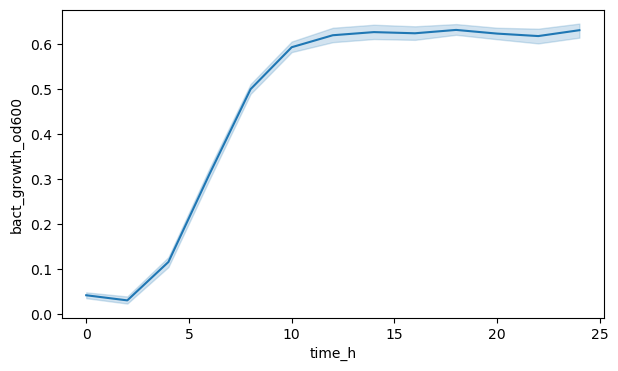

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(data=df_anaer, x="time_h", y="bact_growth_od600")

plt.show()

We can see a line yes, but the shaded area (a confidence interval) indicates, that Seaborn aggregated across all SFN conditions and replicates. Maybe we want to see the OD600 for each SFN separately?
To do this, we can specify the `hue` argument in the function call, which corresponds to plotting each variable value with a different color. Note that Seaborn expects the data in long format for this.
We can also remove the shaded area by setting `errorbar` to `None`.

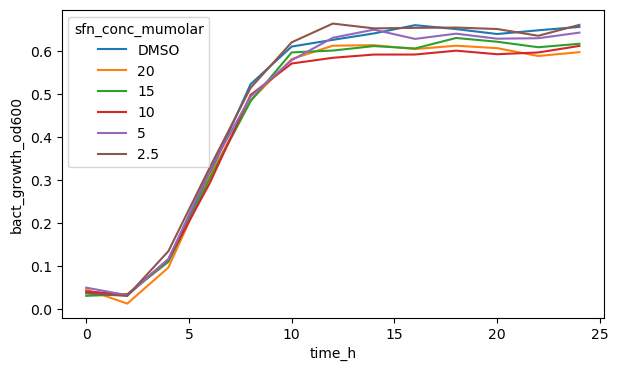

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar=None,
)

plt.show()

If we have multiple variable values with different colors or marker shapes, Seaborn will also automatically plot a legend and put it where it thinks it fits best.

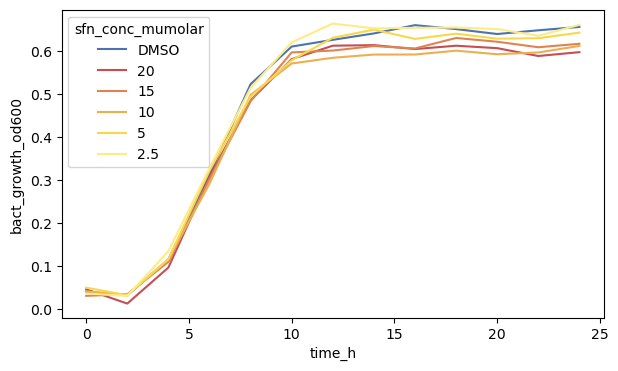

In [25]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar=None,
    palette=SFN_COLORS,
)

plt.show()

Using the `palette` colors we can also adjust the colors to our liking.

We can also plot a scatterplot instead, though since we have defined timepoints, it is not going to be very useful here.
Note that `.scatterplot()` does not have an `errorbar` argument. You should check each plotting function's documentation to see which argument's are accepted.

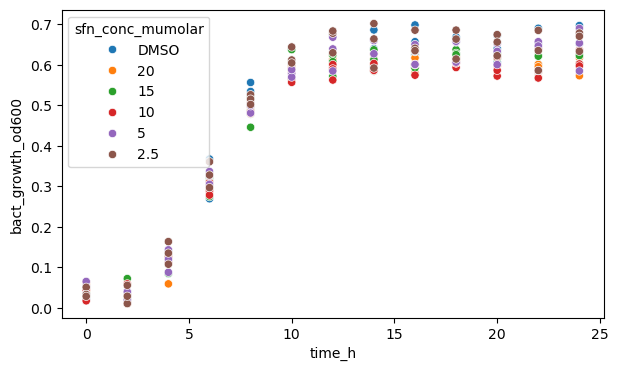

In [9]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.scatterplot(
    data=df_anaer, x="time_h", y="bact_growth_od600", hue="sfn_conc_mumolar"
)

plt.show()

### 1.2 Categorical Plots

In [10]:
df_auc_anaer = data_auc[data_auc["condition"] == "Anaerobic"]

After having shown two plots for continuous data, let us move on to categorical plots where we plot the aggregated dataframe with the area under the curve.

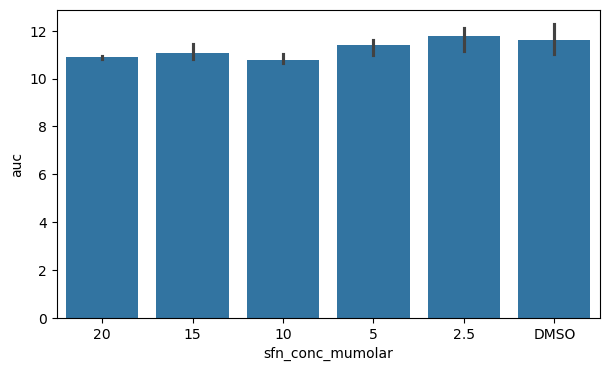

In [11]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_auc_anaer, x="sfn_conc_mumolar", y="auc")

plt.show()

A classical plot to show categories is the barplot which also shows an errorbar by default. We can also see that the x-axis is order in the categories sequence we defined earlier.

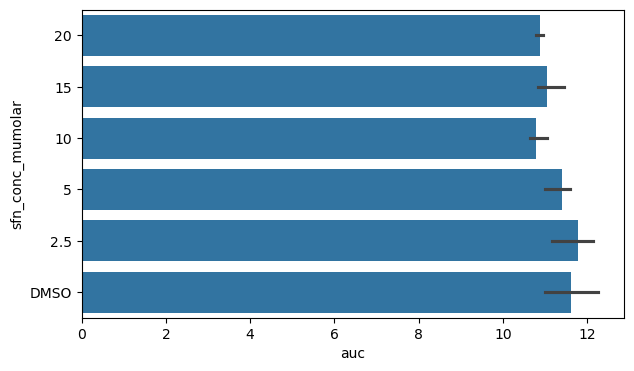

In [12]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_auc_anaer, y="sfn_conc_mumolar", x="auc")

plt.show()

We can switch `x` and `y` to change the orientation of the barplot if we wish.

We can again define a `hue` variable to look deeper into our data. Here we can plot for each SFN category the replicates side-by-side

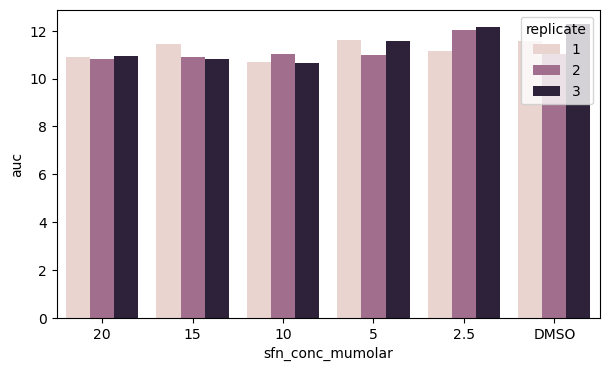

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_auc_anaer, x="sfn_conc_mumolar", y="auc", hue="replicate")

plt.show()

However, we can see that our legend obstructs the view of part of the data. Can we do better?
Yes! Let's move our legend somewhere else. We explicitely call `ax.legend()` which automatically fetches all elements (we will show later how to define them manually to customize the legend). Then, we set the location using `loc` and `bbox_to_anchor`, where the latter uses figure coordinates (in the order x, y) and also set `ncol` to show the replicate colors in one line.

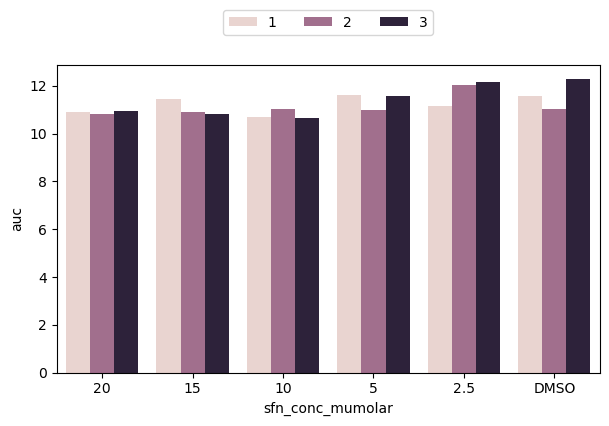

In [24]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_auc_anaer, x="sfn_conc_mumolar", y="auc", hue="replicate")
ax.legend(loc="upper center", bbox_to_anchor=[0.5, 1.2], ncol=3)

plt.show()

There are many more plots Seaborn supports and many more customization options. Next, we will focus on some of the to recreate the plot at the beginning of this notebook.

## 2. Advanced Plotting

We will focus again on the left upper plot for now.

### 2.1 More Lineplot Arguments

As a first step, we will show all arguments needed in the `.lineplot()` function.
We can see that the plot has both lines as well as dots with some errorbars on it. By default, `.lineplot()` draws a 95 % confidence interval as a shaded area. We can change that to use errorbars instead.

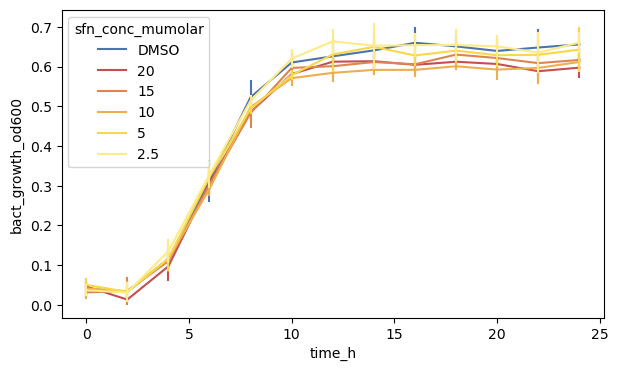

In [30]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    palette=SFN_COLORS,
)

plt.show()

We can also see that there are little 'caps' on the errorbars. These are some special arguments which we specify using a dictionary passing it to the `err_kws` argument.

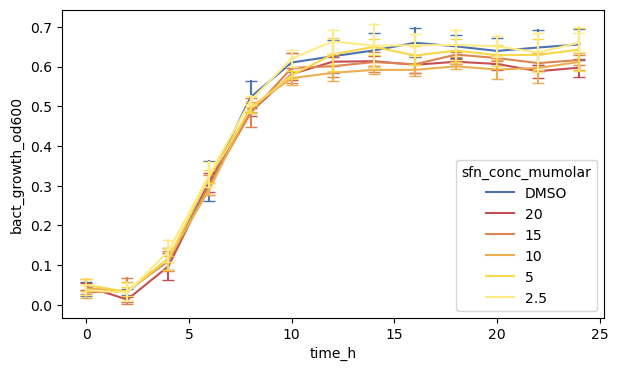

In [31]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    palette=SFN_COLORS,
)

plt.show()

Let us add dots too, called markers in matplotlib syntax. We specify `"o"` (which is also the default) as small dots.
We also set the width of the marker edge to zero, but you can specify that as you want (including the color of the edge which is white by default).

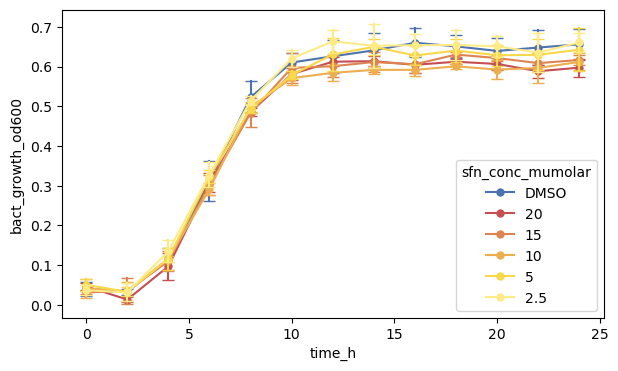

In [33]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
)

plt.show()

This is all. But, before we move on, it is good practice to also specify the `axes` element. By default, Seaborn uses the last one that was specified (here the first line), but it is better to be explicit.

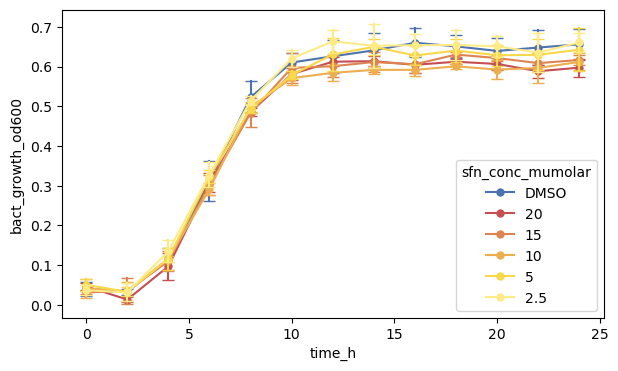

In [34]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

plt.show()

Next, we make the x- and y-axis prettier and more readable.

### 2.2 Customizing the Axes - Labels, Ticks, Etc.

**2.2.1 Plot Limits**

By default, Matplotlib/Seaborn draws the plotting area based on the minumun and maximum of what was specified, inlcuding some margin. We can set this explicitely using `ax.set_xlim()` for the x-axis (and correspondingly for the y-axis).
We set the limits to what is shown in the figure

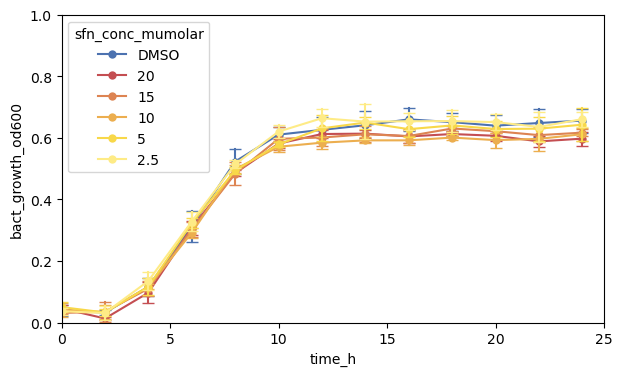

In [36]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)

# set y-axis properties
ax.set_ylim(0, 1.0)

plt.show()

**2.2.2 Specify Axis Labels**

We renamed the columns in the beginning to be better for programming, but they might not be necessarily optimal for being read in a graphic. We will change that now by explicitely setting the axis labels.
Note also that we make use of LaTeX rendering for the y-axis to make the '600' in OD600 lowercase. The `labelpad` argument indicates the padding space between the actual axis and the label.

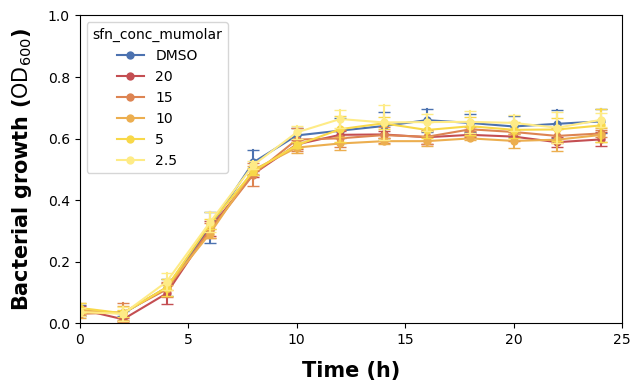

In [38]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

plt.show()

**2.2.3 Change Axis Tick Sizes**

We have changed the labels now and made them bigger too, so we should to the same to the ticks (the lines and numbers marking the data points).
We will make the ticks wider and longer.

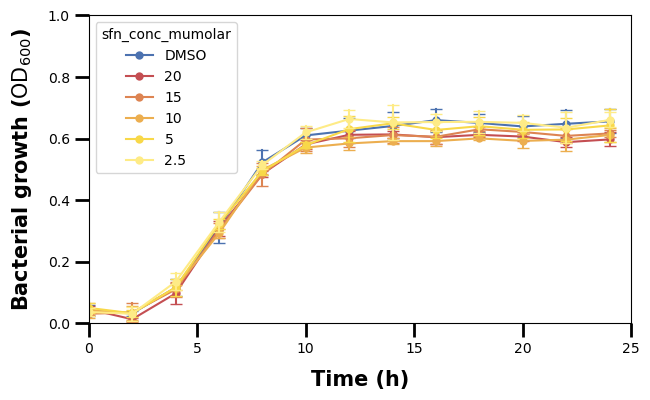

In [40]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_tick_params(width=2, length=10)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_tick_params(width=2, length=10)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

plt.show()

We can see though that, beside the *major* tick lines, there are also some *minor* ones.
We also see that the frequency of the ticks in the plot is different. The major ticks on the x-axis seem to be in intervals of 10, while the minor ones in intervals of 1.
To set them, we make use of Matplotlib's ticker locators (setting the location of ticks). We use the `ax.<axis>.set_<kind>_locator()` function and pass to it an object of the `ticker` module, here `MultipleLocator` that specifies in what intervals the ticks shall be drawn.

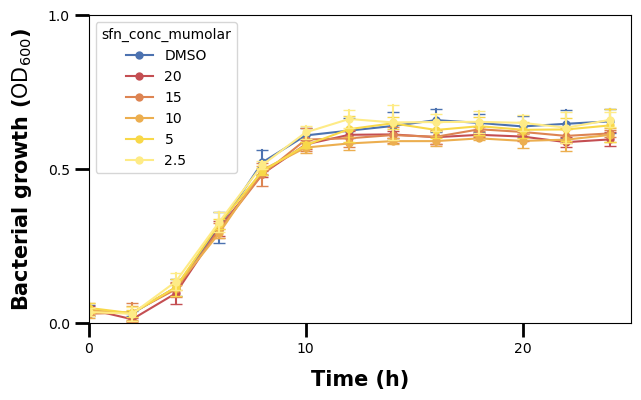

In [44]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_tick_params(width=2, length=10)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_tick_params(width=2, length=10)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

plt.show()

We have set the major ticks for the x- and y-axis, and can now do the same for the minor ones.

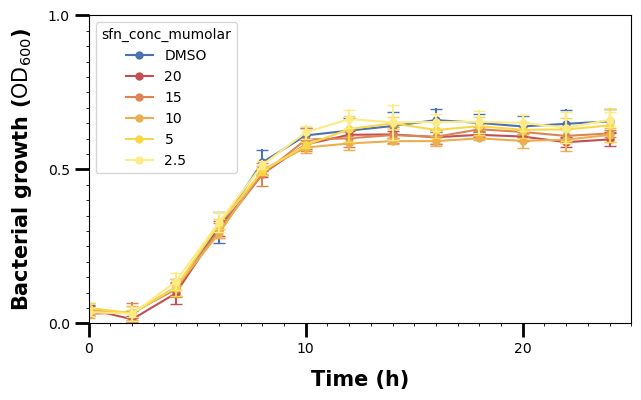

In [47]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(width=2, length=10)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(width=2, length=10)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

plt.show()

By default, the `.set_tick_params()` call specifies the major ones, so we have to use the `which` argument to specify wether we want to adjust the major or minor ticks.
We make the minor ticks a bit smaller than the major ones.

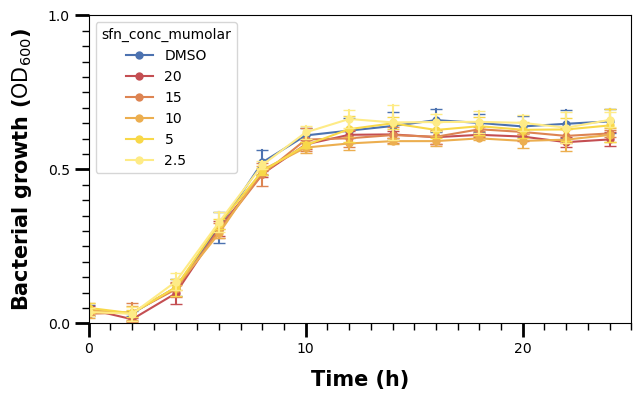

In [48]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

plt.show()

We should also increase the fontsize of the tick labels.
We use `ax.tick_params()` for this below. We could also use `ax.set_xticks()`, but we would also need to specify what our ticks are in that case. One of the solutions for the exercises shows how to do that.

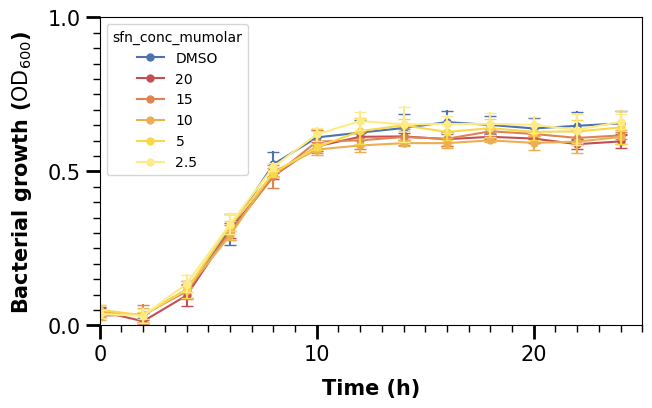

In [53]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

plt.show()

Finally, we will also change the whole axis-lines. We can see that only the left and bottom one are plotted.
In Matplotlib, they are defined as "spines", and we set them as follows in a for-loop, specifying the linewidth (2 for left/bottom and 0 for right/top to make the latter ones invisible).

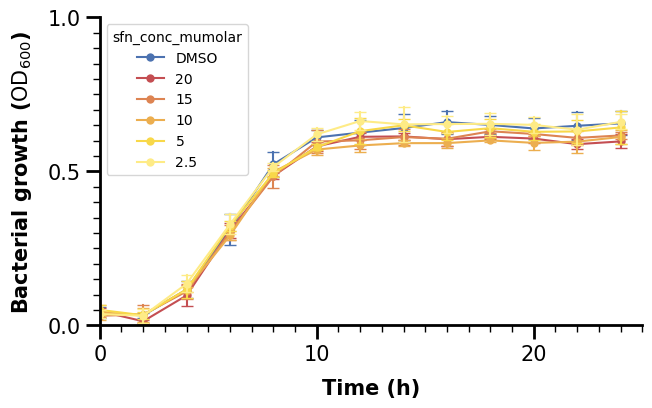

In [54]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

plt.show()

### 2.3 Customizing the Legend

**2.3.1 Basic Legend Customization**

The legend can also receive some attention. First, let us move it to a better location, e.g. to the right of the plot like in the paper.

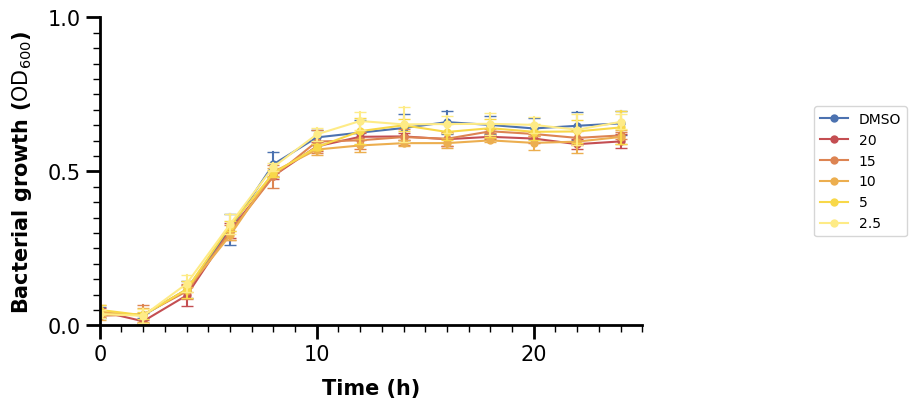

In [60]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
ax.legend(loc="right", bbox_to_anchor=[1.5, 0.5])

plt.show()

Oops, the new legend does not have any title. But that is fine, we should specify it ourselves anyway, again making use of   LaTeX.
Let's also remove the frame around the legend.

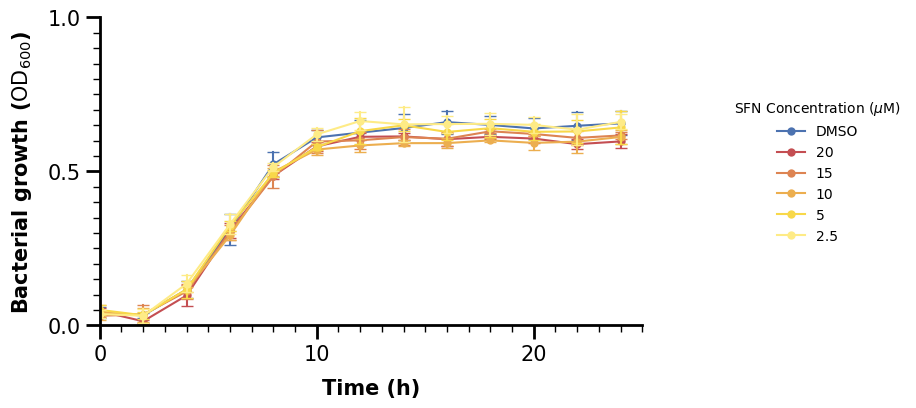

In [59]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
ax.legend(
    title="SFN Concentration ($\\mu$M)",
    loc="right",
    bbox_to_anchor=[1.5, 0.5],
    frameon=False,
)

plt.show()

We should increase the fontsize too of the legend. The `fontsize` argument however only affects the variable labels. For the title, we set our call to `ax.legend()` to a variable, access the title property and adjust its fontsize afterwards.

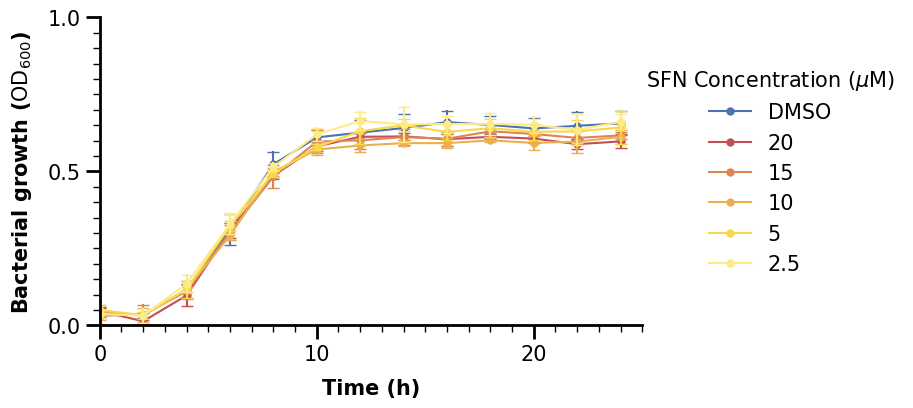

In [58]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
lgnd = ax.legend(
    fontsize=15,
    title="SFN Concentration ($\\mu$M)",
    loc="right",
    bbox_to_anchor=[1.5, 0.5],
    frameon=False,
)
lgnd.get_title().set_fontsize(15)

plt.show()

**2.3.2 Advanced Legend Customization**

We can see that our legend markers are a bit too small. This might be a problem if we would further increase the size of the whole plot. Hence, it would make sense to specify their size too, right?
However, this is less trivial to do than most other things shown so far. But, we will show one way to do it which should suffice for most cases.

What we need to do is specify the `handles` of our legend. The legend has two primary attributes: handles and labels (i.e., the markers for the variables and their names).
We make use of the fact that the legend handles/markers are essentially the same type of object as what is drawn in the main plot area. In the case of a lineplot, they are 2-dimensional lines, i.e. `Line2D` objects. We create thos in a list comprehension (essentially a loop) with empty data (emtpy lists) and specify a larger markersize and linewidth than `sns.lineplot()` used.

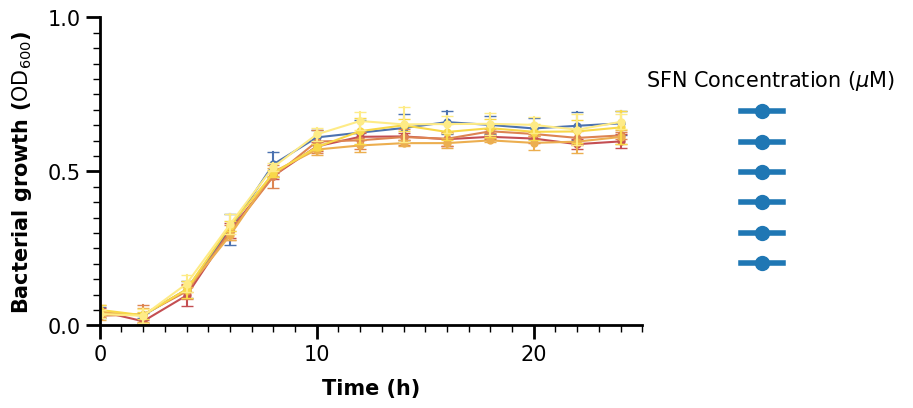

In [62]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
lgnd = ax.legend(
    handles=[
        mlines.Line2D([], [], marker="o", markersize=10, linewidth=4)
        for _ in SFN_COLORS.items()
    ],
    fontsize=15,
    title="SFN Concentration ($\\mu$M)",
    loc="right",
    bbox_to_anchor=[1.5, 0.5],
    frameon=False,
)
lgnd.get_title().set_fontsize(15)

plt.show()

The size looks better, but now are labels are gone. We could set the `labels` argument in the `ax.legend()` call or the `label` argument inside each call of `mline.Line2D` inside the loop, either is fine. We use the latter to loop through our dictionary with colors so we can set the corresponding color at the same time.

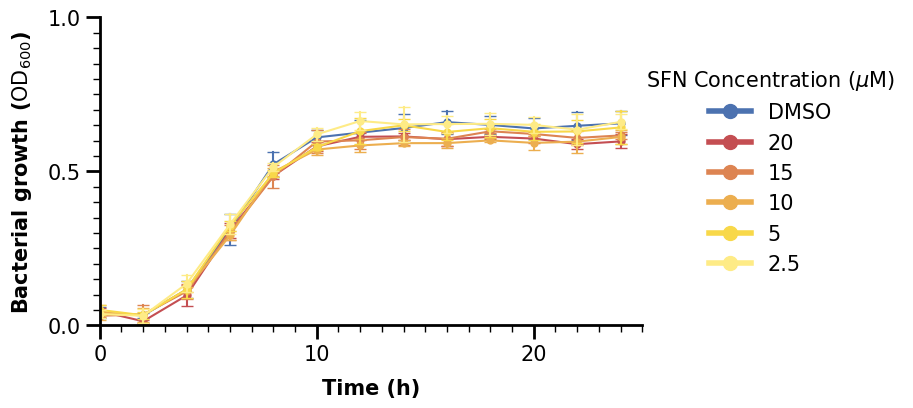

In [65]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
lgnd = ax.legend(
    handles=[
        mlines.Line2D([], [], color=c, marker="o", markersize=10, linewidth=4, label=l)
        for l, c in SFN_COLORS.items()
    ],
    fontsize=15,
    title="SFN Concentration ($\\mu$M)",
    loc="right",
    bbox_to_anchor=[1.5, 0.5],
    frameon=False,
)
lgnd.get_title().set_fontsize(15)

plt.show()

Now we are finished with the plot in the upper left, we can just give it a title too. We can copy and paste the code to do the same for the lineplot with aerobic data.

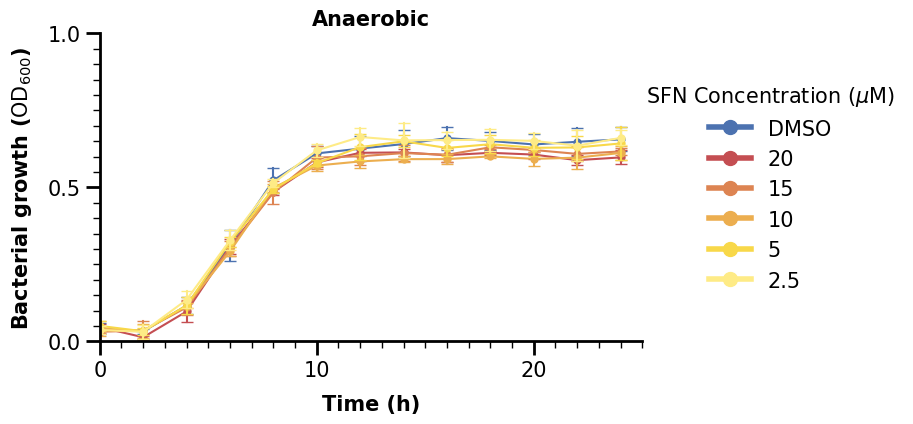

In [66]:
fig, ax = plt.subplots(figsize=(7, 4))

# main plot call
sns.lineplot(
    data=df_anaer,
    x="time_h",
    y="bact_growth_od600",
    hue="sfn_conc_mumolar",
    errorbar="sd",
    err_style="bars",
    err_kws={"capsize": 4},
    markers=True,
    marker="o",
    markeredgewidth=0,
    palette=SFN_COLORS,
    ax=ax,
)

# set x-axis properties
ax.set_xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which="major", width=2, length=10)
ax.xaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel("Time (h)", fontdict={"size": 15, "weight": "bold"}, labelpad=10)

# set y-axis properties
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_tick_params(which="major", width=2, length=10)
ax.yaxis.set_tick_params(which="minor", width=1, length=5)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Bacterial growth ($\\text{OD}_{600}$)",
    fontdict={"size": 15, "weight": "bold"},
    labelpad=10,
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
lgnd = ax.legend(
    handles=[
        mlines.Line2D([], [], color=c, marker="o", markersize=10, linewidth=4, label=l)
        for l, c in SFN_COLORS.items()
    ],
    fontsize=15,
    title="SFN Concentration ($\\mu$M)",
    loc="right",
    bbox_to_anchor=[1.5, 0.5],
    frameon=False,
)
lgnd.get_title().set_fontsize(15)

# lastly, set the title
ax.set_title("Anaerobic", fontdict={"size": 15, "weight": "bold"})

plt.show()

### 2.4 Categorical Plot with Significance Indicators

We now turn our attention to the plot on the upper right, using the aggregated data. We skip most steps here as they are similar. We only note that we are using a stripplot to visualize categorical data with dots and also a pointplot to show some errorbars.

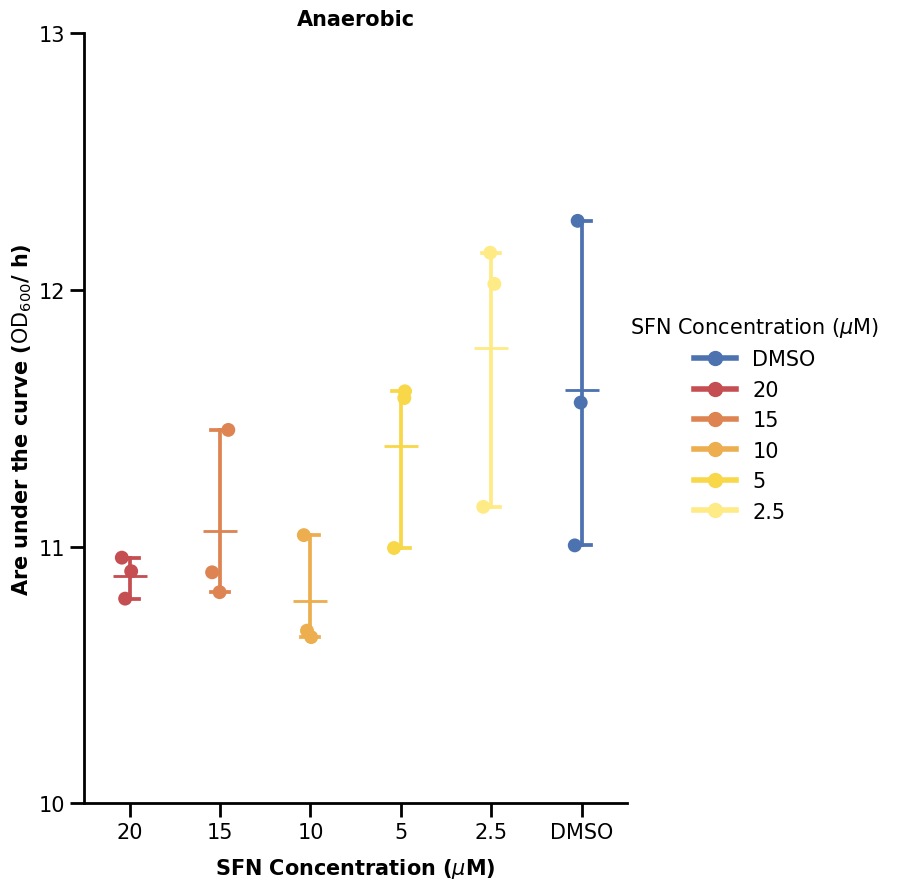

In [67]:
fig, ax = plt.subplots(figsize=(7, 10))

sns.pointplot(
    data=data_auc[data_auc["condition"] == "Anaerobic"],
    x="sfn_conc_mumolar",
    y="auc",
    hue="sfn_conc_mumolar",
    marker="_",
    markersize=25,
    capsize=0.2,
    palette=SFN_COLORS,
)
p2 = sns.stripplot(
    data=data_auc[data_auc["condition"] == "Anaerobic"],
    x="sfn_conc_mumolar",
    y="auc",
    hue="sfn_conc_mumolar",
    size=10,
    palette=SFN_COLORS,
)

# set x-axis properties
ax.xaxis.set_tick_params(width=2, length=10)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel(
    "SFN Concentration ($\\mu$M)", labelpad=10, fontdict={"size": 15, "weight": "bold"}
)

# set y-axis properties
ax.set_ylim(10, 13)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_tick_params(width=2, length=10)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Are under the curve ($\\text{OD}_{600}$/ h)",
    fontdict={"size": 15, "weight": "bold"},
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
lgnd = ax.legend(
    handles=[
        mlines.Line2D([], [], color=c, marker="o", markersize=10, linewidth=4, label=l)
        for l, c in SFN_COLORS.items()
    ],
    fontsize=15,
    title="SFN Concentration ($\\mu$M)",
    loc="right",
    bbox_to_anchor=[1.5, 0.5],
    frameon=False,
)
lgnd.get_title().set_fontsize(15)

# lastly, set the title
ax.set_title("Anaerobic", fontdict={"size": 15, "weight": "bold"})

plt.show()

We will now show one way to plot the significance bars. We made a small function to do that. What it does is just plot some lines and also add some text above the line (the significance star). What we define is just where we want our significance bar to start (the `y` argument) and between which x-indices to span it over (the `xs` argument).
For categorical data, the x-axis coordinates are 0, 1, 2, ... all up to how many we have (minus one).

In [68]:
def plot_significance(xs, y, labels=["*"], height=0.1, ax=None):
    for (x_left, x_right), y_start, lab in zip(xs, y, labels):
        ax.plot(
            [x_left, x_left],
            [y_start, y_start + height],
            linewidth=3,
            color="black",
        )
        ax.plot(
            [x_right, x_right],
            [y_start, y_start + height],
            linewidth=3,
            color="black",
        )
        ax.plot(
            [x_left, x_left, x_right, x_right],
            [y_start, y_start + height / 2, y_start + height / 2, y_start],
            linewidth=3,
            color="black",
        )
        ax.text(
            (x_left + x_right) / 2,
            y_start + height,
            lab,
            horizontalalignment="center",
            verticalalignment="bottom",
            fontsize=25,
        )

Hence, if we want the bar to span between 20 and DMSO (first and last), we specify `xs` as `(0, 5)`.

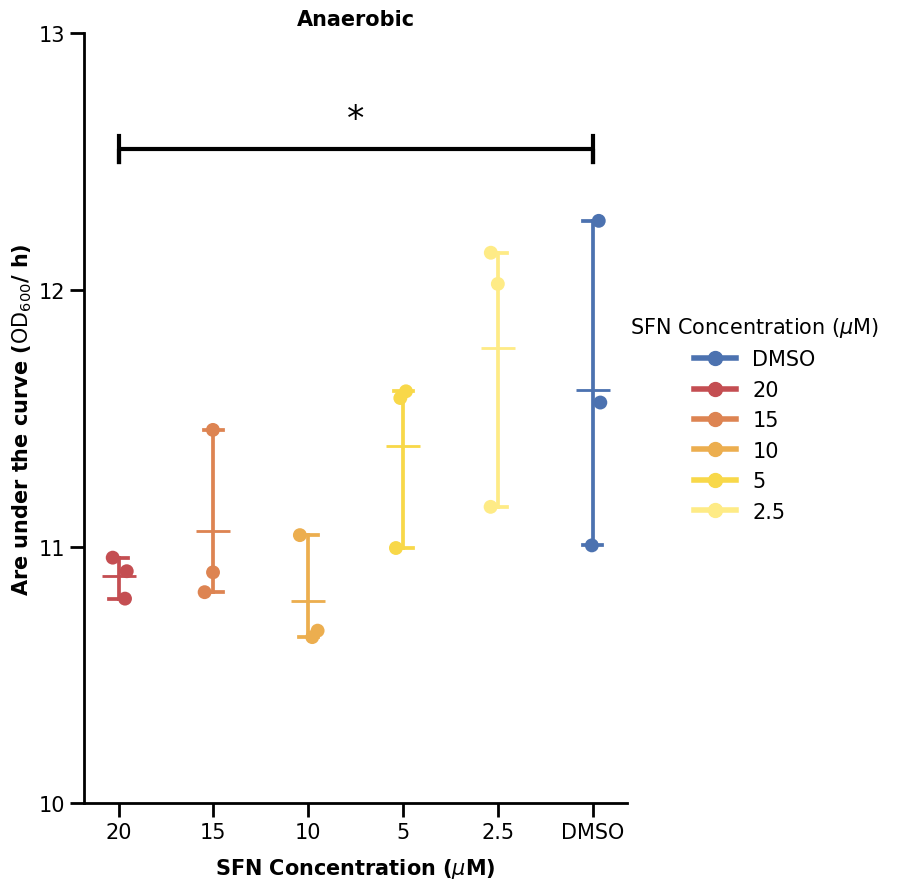

In [69]:
fig, ax = plt.subplots(figsize=(7, 10))

sns.pointplot(
    data=data_auc[data_auc["condition"] == "Anaerobic"],
    x="sfn_conc_mumolar",
    y="auc",
    hue="sfn_conc_mumolar",
    marker="_",
    markersize=25,
    capsize=0.2,
    palette=SFN_COLORS,
)
p2 = sns.stripplot(
    data=data_auc[data_auc["condition"] == "Anaerobic"],
    x="sfn_conc_mumolar",
    y="auc",
    hue="sfn_conc_mumolar",
    size=10,
    palette=SFN_COLORS,
)

# set x-axis properties
ax.xaxis.set_tick_params(width=2, length=10)
ax.tick_params(axis="x", labelsize=15)
ax.set_xlabel(
    "SFN Concentration ($\\mu$M)", labelpad=10, fontdict={"size": 15, "weight": "bold"}
)

# set y-axis properties
ax.set_ylim(10, 13)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_tick_params(width=2, length=10)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel(
    "Are under the curve ($\\text{OD}_{600}$/ h)",
    fontdict={"size": 15, "weight": "bold"},
)

# adjust the "frame" of the plot
for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
    ax.spines[pos].set_linewidth(lw)

# make a customized legend
lgnd = ax.legend(
    handles=[
        mlines.Line2D([], [], color=c, marker="o", markersize=10, linewidth=4, label=l)
        for l, c in SFN_COLORS.items()
    ],
    fontsize=15,
    title="SFN Concentration ($\\mu$M)",
    loc="right",
    bbox_to_anchor=[1.5, 0.5],
    frameon=False,
)
lgnd.get_title().set_fontsize(15)

# indicate statistical significances
plot_significance([(0, 5)], [12.5], labels=["*"], ax=ax)

# lastly, set the title
ax.set_title("Anaerobic", fontdict={"size": 15, "weight": "bold"})

plt.show()

## 3. Figure Composition

Now, we can create the final plot consisting of all the 4 subplots.
Below, we define functions to draw the two types of plots we have. Note that we removed the legend from the right plot type, as it is not drawn there in the paper figure. As such, we set the `legend` argument to `False` in the `.pointplot()` and `.stripplot()` calls.

In [122]:
def plot_lineplot(data, condition, xlims, ylims, ax):
    sns.lineplot(
        data=data[data["condition"] == condition],
        x="time_h",
        y="bact_growth_od600",
        hue="sfn_conc_mumolar",
        errorbar="sd",
        err_style="bars",
        err_kws={"capsize": 4},
        markers=True,
        marker="o",
        markeredgewidth=0,
        palette=SFN_COLORS,
        ax=ax,
    )

    # set x-axis properties
    ax.set_xlim(*xlims)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_tick_params(which="major", width=2, length=10)
    ax.xaxis.set_tick_params(which="minor", width=1, length=5)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_xlabel("Time (h)", labelpad=10, fontdict={"size": 15, "weight": "bold"})

    # set y-axis properties
    ax.set_ylim(*ylims)
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_tick_params(which="major", width=2, length=10)
    ax.yaxis.set_tick_params(which="minor", width=1, length=5)
    ax.tick_params(axis="y", labelsize=15)
    ax.set_ylabel(
        "Bacterial growth ($\\text{OD}_{600}$)",
        fontdict={"size": 15, "weight": "bold"},
        labelpad=10,
    )

    # adjust the "frame" of the plot
    for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
        ax.spines[pos].set_linewidth(lw)

    # make a customized legend
    lgnd = ax.legend(
        handles=[
            mlines.Line2D(
                [], [], color=c, marker="o", markersize=10, linewidth=4, label=l
            )
            for l, c in SFN_COLORS.items()
        ],
        fontsize=15,
        title="SFN Concentration ($\\mu$M)",
        loc="right",
        bbox_to_anchor=[1.4, 0.5],
        frameon=False,
    )
    lgnd.get_title().set_fontsize(15)

    # lastly, set the title
    ax.set_title(condition, fontdict={"size": 15, "weight": "bold"})


def plot_categorical_plot(data, condition, ylims, ax):
    sns.pointplot(
        data=data[data["condition"] == condition],
        x="sfn_conc_mumolar",
        y="auc",
        hue="sfn_conc_mumolar",
        marker="_",
        markersize=25,
        capsize=0.2,
        palette=SFN_COLORS,
        legend=False,
        ax=ax,
    )
    sns.stripplot(
        data=data[data["condition"] == condition],
        x="sfn_conc_mumolar",
        y="auc",
        hue="sfn_conc_mumolar",
        size=10,
        palette=SFN_COLORS,
        legend=False,
        ax=ax,
    )

    # set x-axis properties
    ax.xaxis.set_tick_params(width=2, length=10)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_xlabel(
        "SFN Concentration ($\\mu$M)",
        labelpad=10,
        fontdict={"size": 15, "weight": "bold"},
    )

    # set y-axis properties
    ax.set_ylim(*ylims)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_tick_params(width=2, length=10)
    ax.tick_params(axis="y", labelsize=15)
    ax.set_ylabel(
        "Are under the curve ($\\text{OD}_{600}$/ h)",
        fontdict={"size": 15, "weight": "bold"},
    )

    # adjust the "frame" of the plot
    for pos, lw in zip(["bottom", "left", "top", "right"], [2, 2, 0, 0]):
        ax.spines[pos].set_linewidth(lw)

    # lastly, set the title
    ax.set_title(condition, fontdict={"size": 15, "weight": "bold"})

### 3.1 Default using `.subplots()`

The easiest way to do a grid is to make use of subplots. One way is to use the oneliner
`fig, ax = plt.subplots(nrows=<number-of-rows>, ncols=<number-of-columns>)`, creating a grid of equally spaced subplots.
We can call it without any further plot functions just to see what the grid looks like.

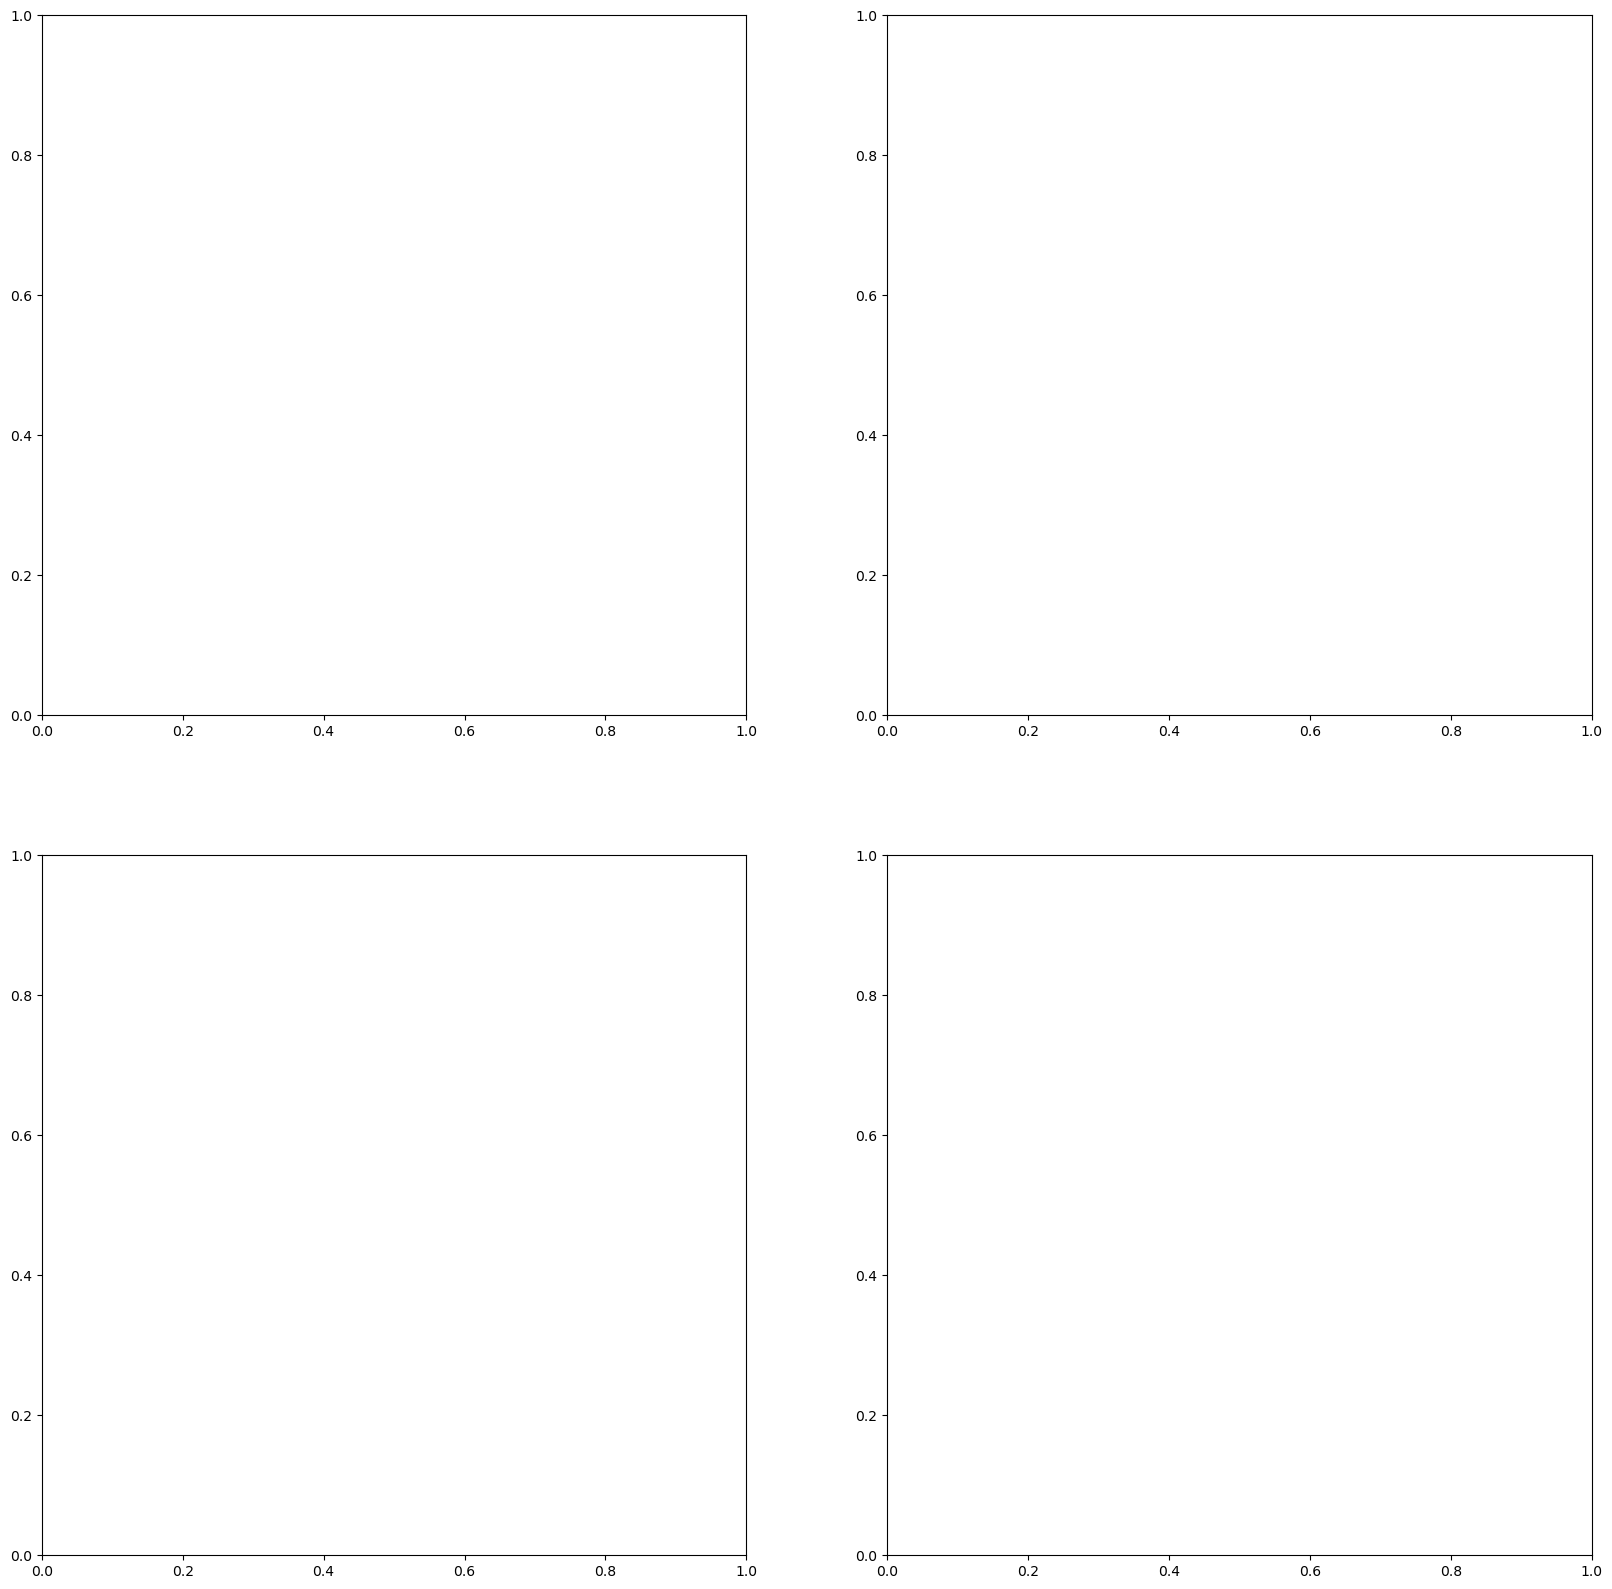

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

plt.show()

If we have more than one subplot, `ax` will be a NumPy array of as many `axes` objects as our grid is large (in this case 2 x 2 = 4).
We can iterate through some containers and populate the grid as we show below.

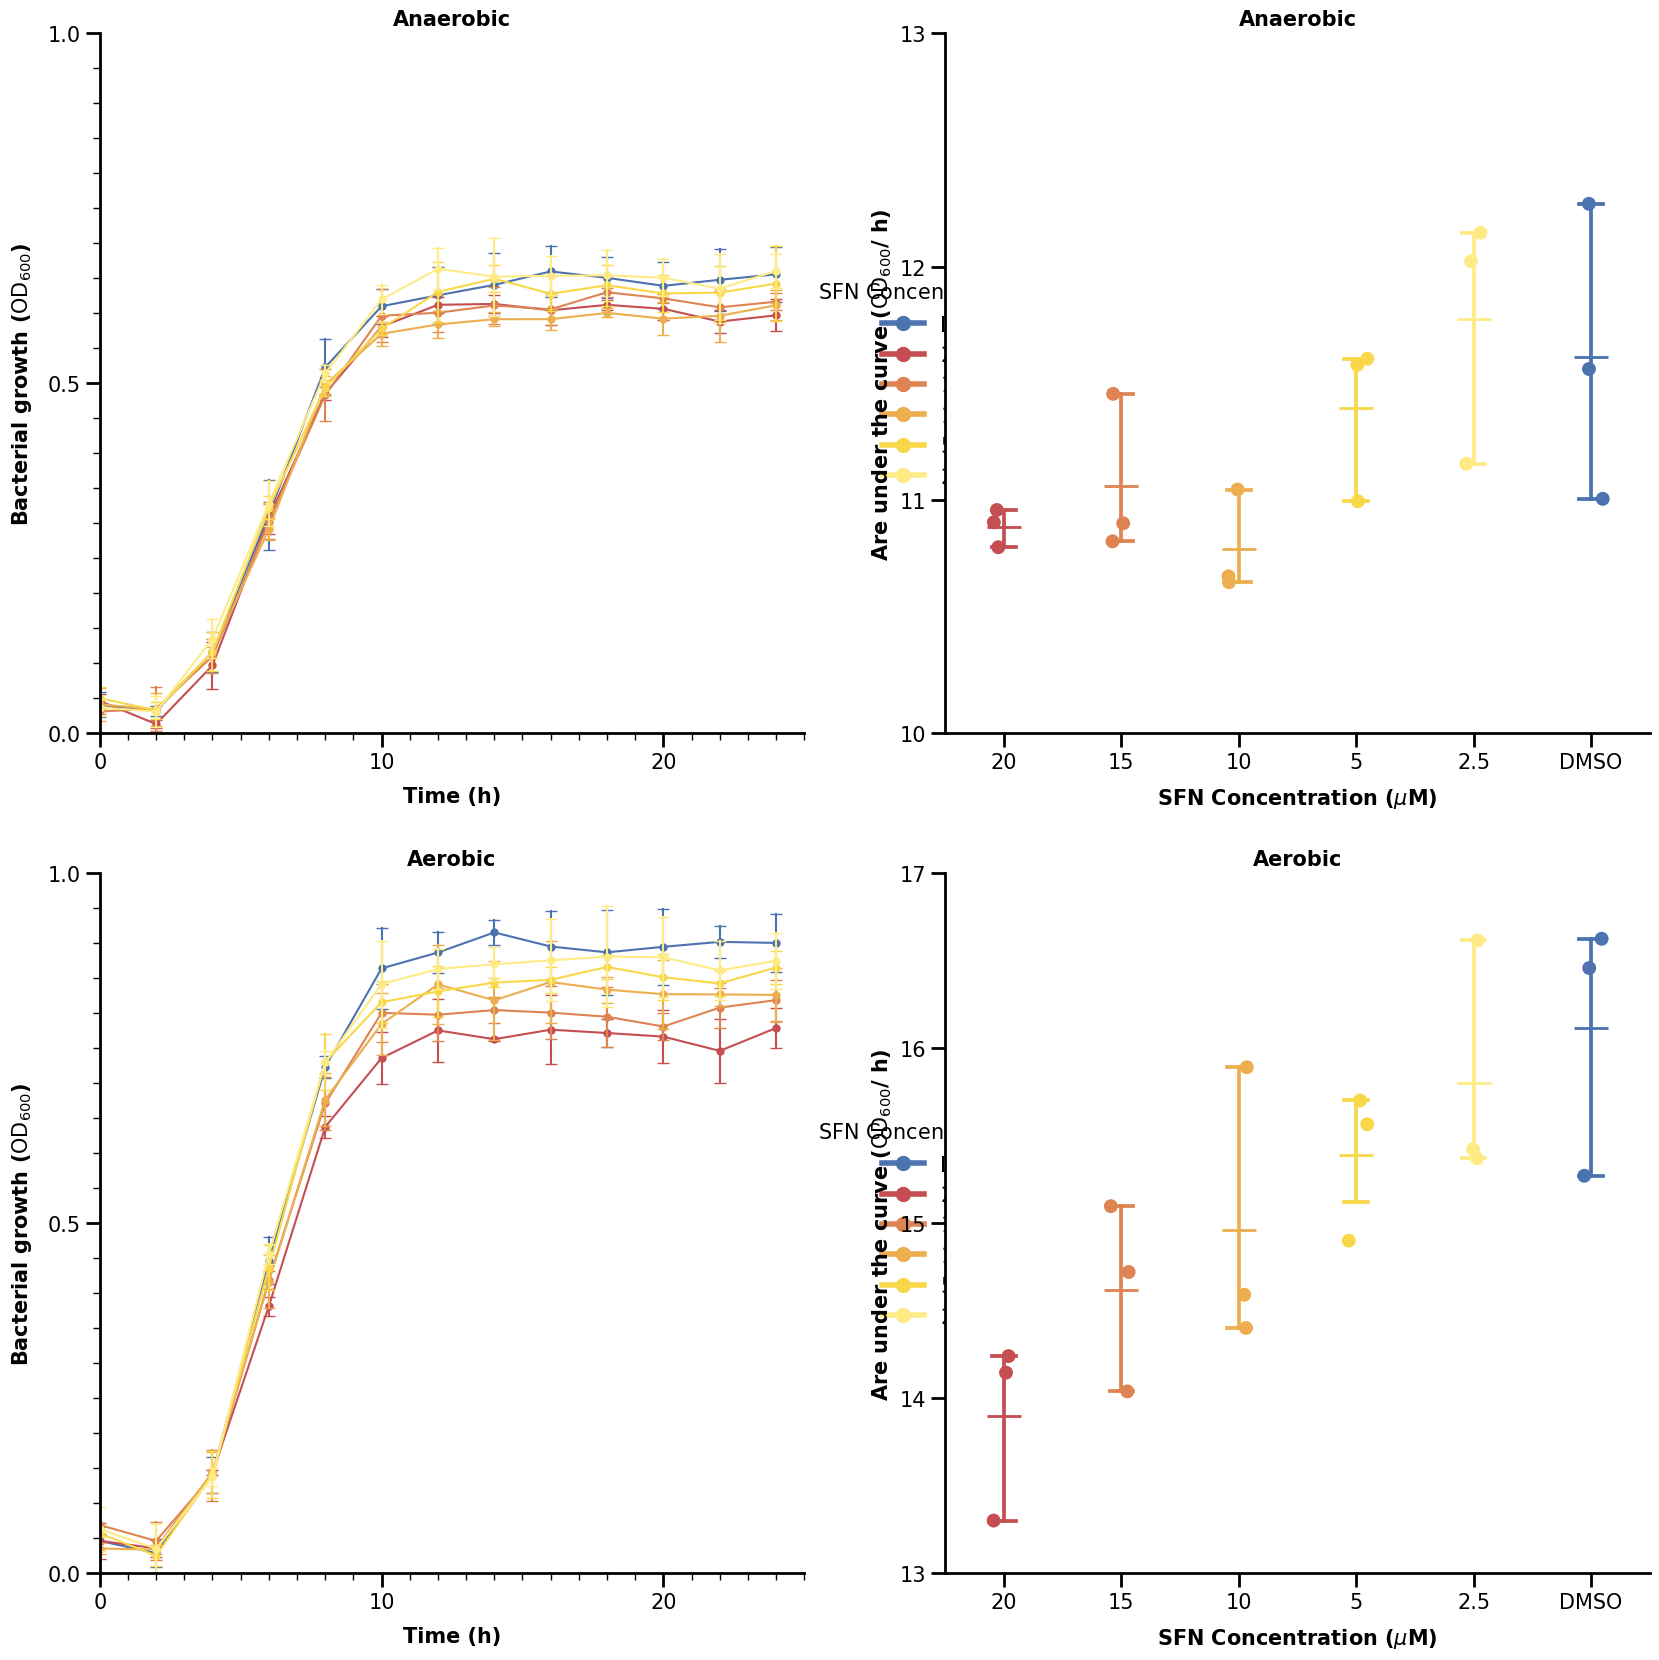

In [124]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

for r, cond in enumerate(["Anaerobic", "Aerobic"]):
    if r == 0:
        cat_lims = (10, 13)
    else:
        cat_lims = (13, 17)
    for c in range(2):
        if c == 0:
            plot_lineplot(data, cond, (0, 25), (0, 1.0), ax[r, c])

        else:
            plot_categorical_plot(data_auc, cond, cat_lims, ax[r, c])

plt.show()

That looks somewhat close to the real plot. However, we can see that the legends are obscured by the categorical plots on the right. A better way would be to specify the spacing for each sub-plotting area in the grid. We will show how to do that in the last section using `Gridspec`.

### 3.2 Advanced Composition using `Gridspec`

Gridspec allows us to specify the boundaries of our plotting areas. We define two Gridspec areas here: one for the left plot, one for the right. The Gridspec's make use of **figure** coordinates, where we specify the `left`, `right`, `top`, and/or `bottom` arguments.
Note that for these arguments, the start is at the lower left corner. We show below again for empty plots how the grid looks now.

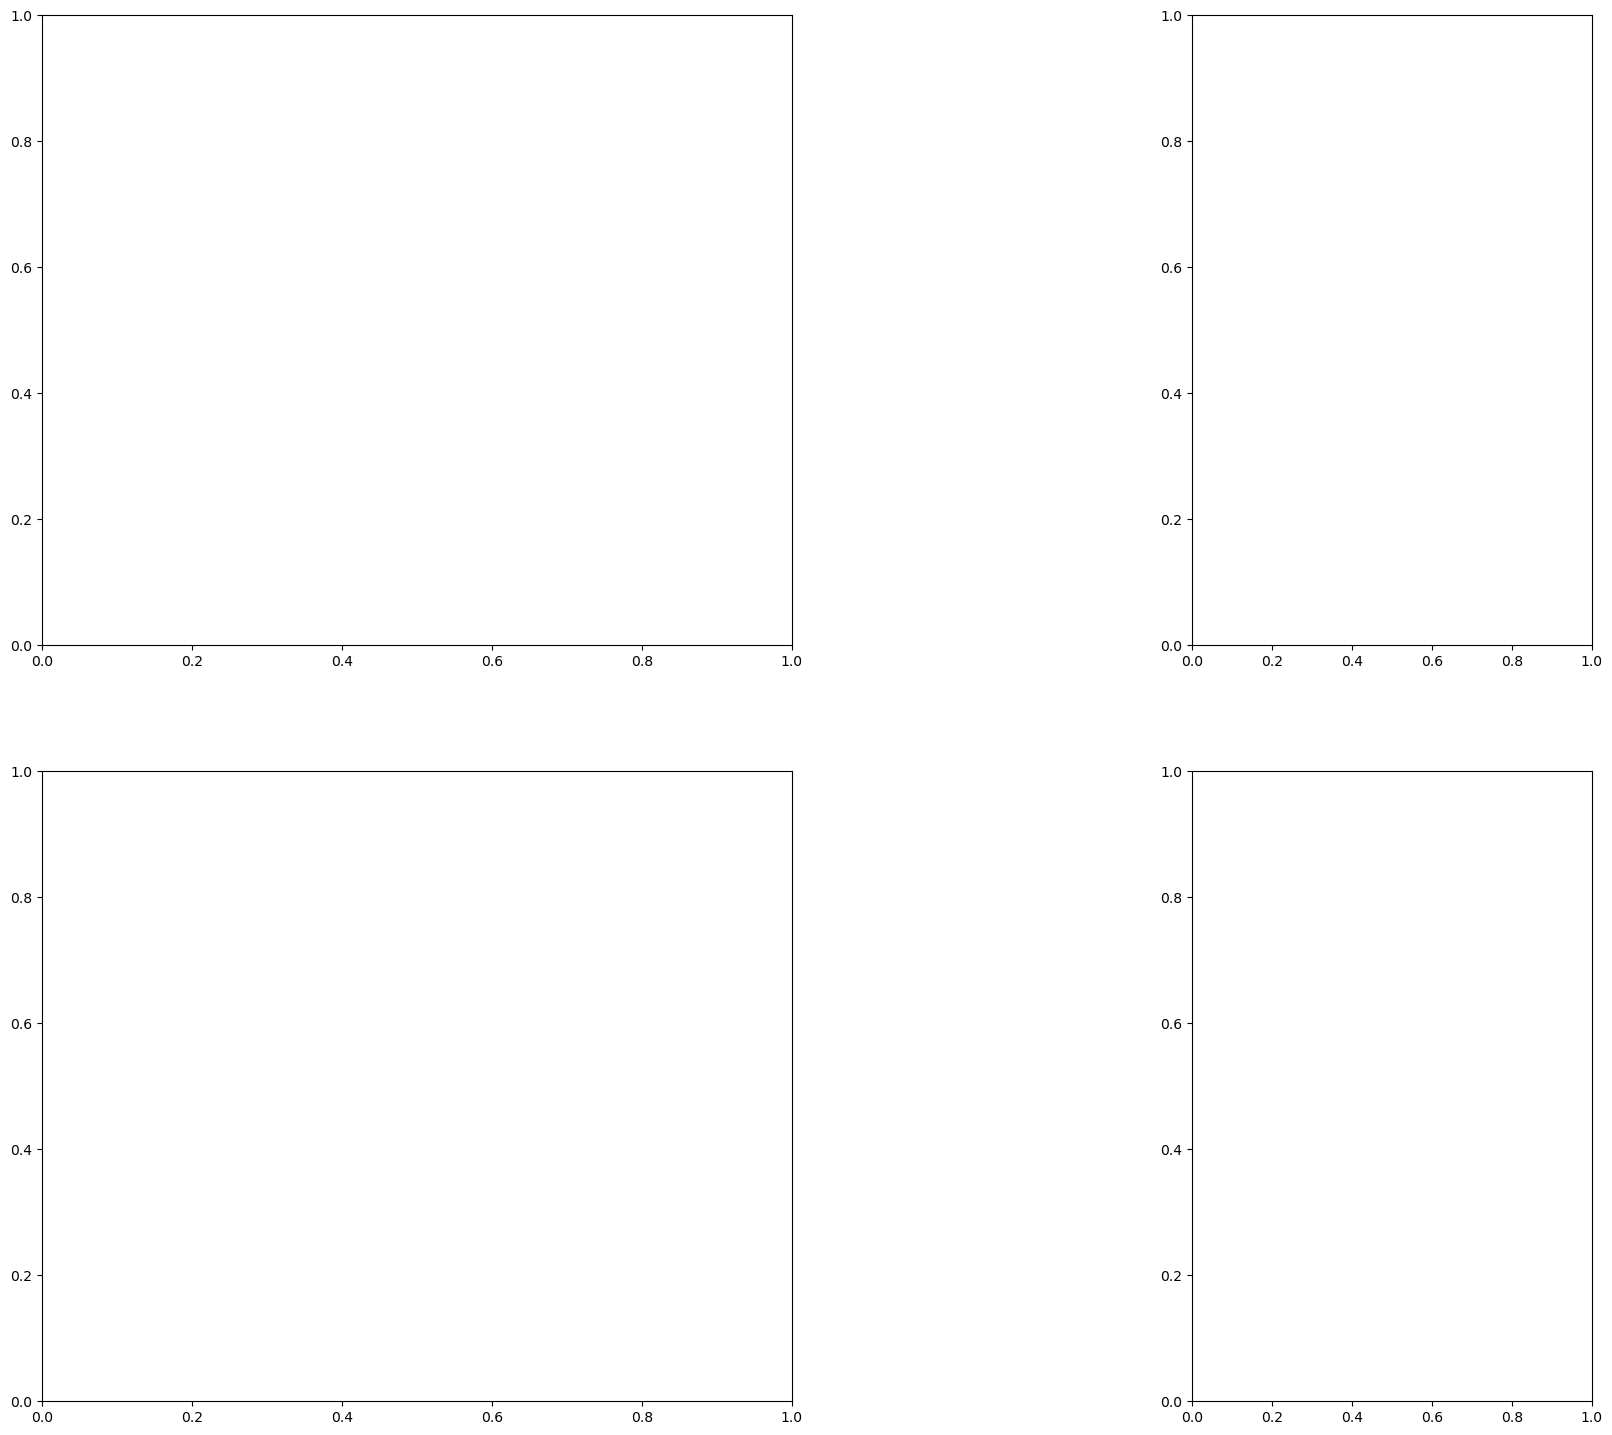

In [147]:
fig = plt.figure(figsize=(20, 18))

gs_line = fig.add_gridspec(nrows=2, ncols=1, right=0.5)
gs_cat = fig.add_gridspec(nrows=2, ncols=1, left=0.7)

for r, cond in enumerate(["Anaerobic", "Aerobic"]):
    for c in range(2):
        if c == 0:
            ax = fig.add_subplot(gs_line[r])

        else:
            ax = fig.add_subplot(gs_cat[r])

plt.show()

We can use `hspace` to add horizontal spacing between our subplots in our gridspec.

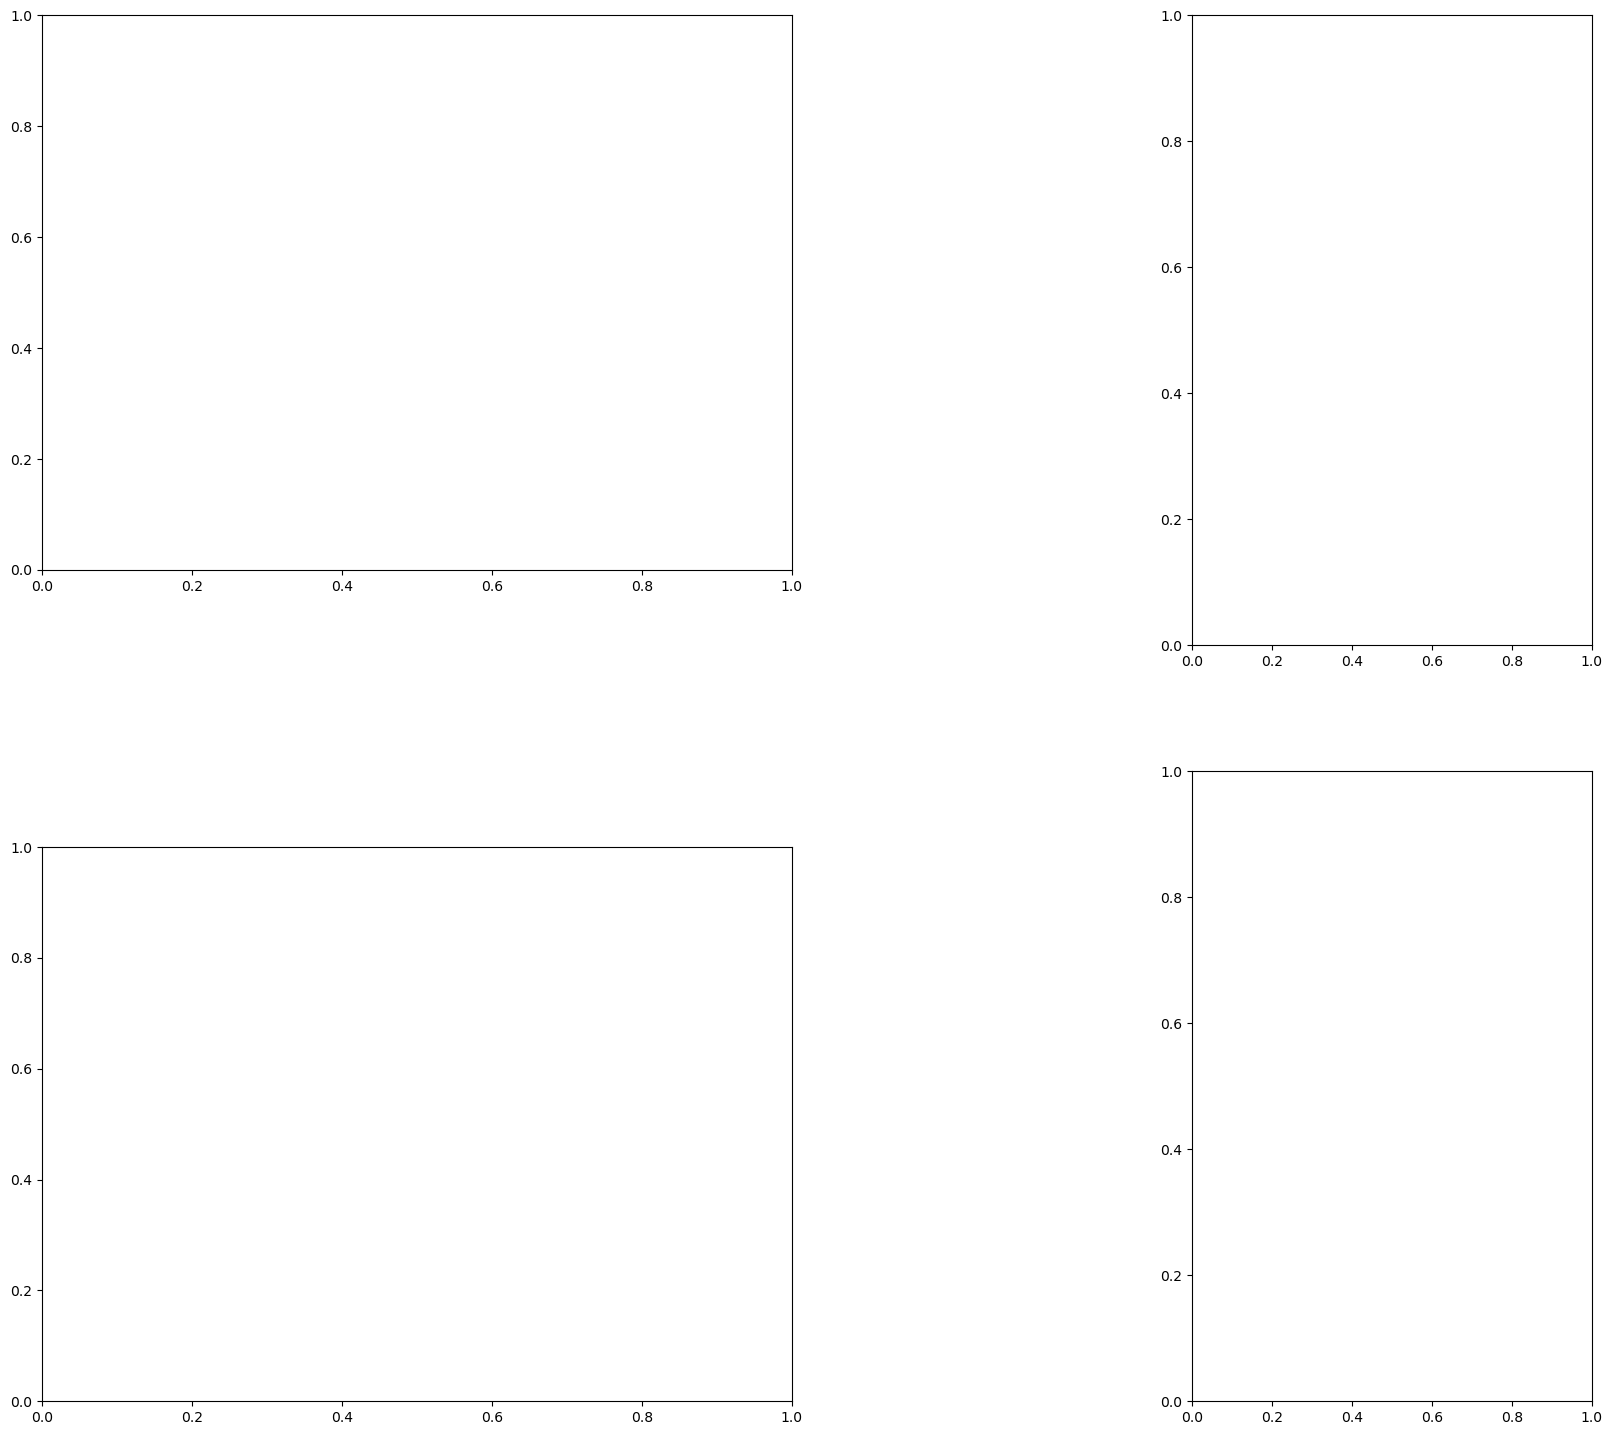

In [146]:
fig = plt.figure(figsize=(20, 18))

gs_line = fig.add_gridspec(nrows=2, ncols=1, right=0.5, hspace=0.5)
gs_cat = fig.add_gridspec(nrows=2, ncols=1, left=0.7)

for r, cond in enumerate(["Anaerobic", "Aerobic"]):
    for c in range(2):
        if c == 0:
            ax = fig.add_subplot(gs_line[r])

        else:
            ax = fig.add_subplot(gs_cat[r])

plt.show()

We now add in our plotting functions from before where we define each `axes` via the standard `fig.add_subplot()` call - only now we add an element of our gridspec to it.

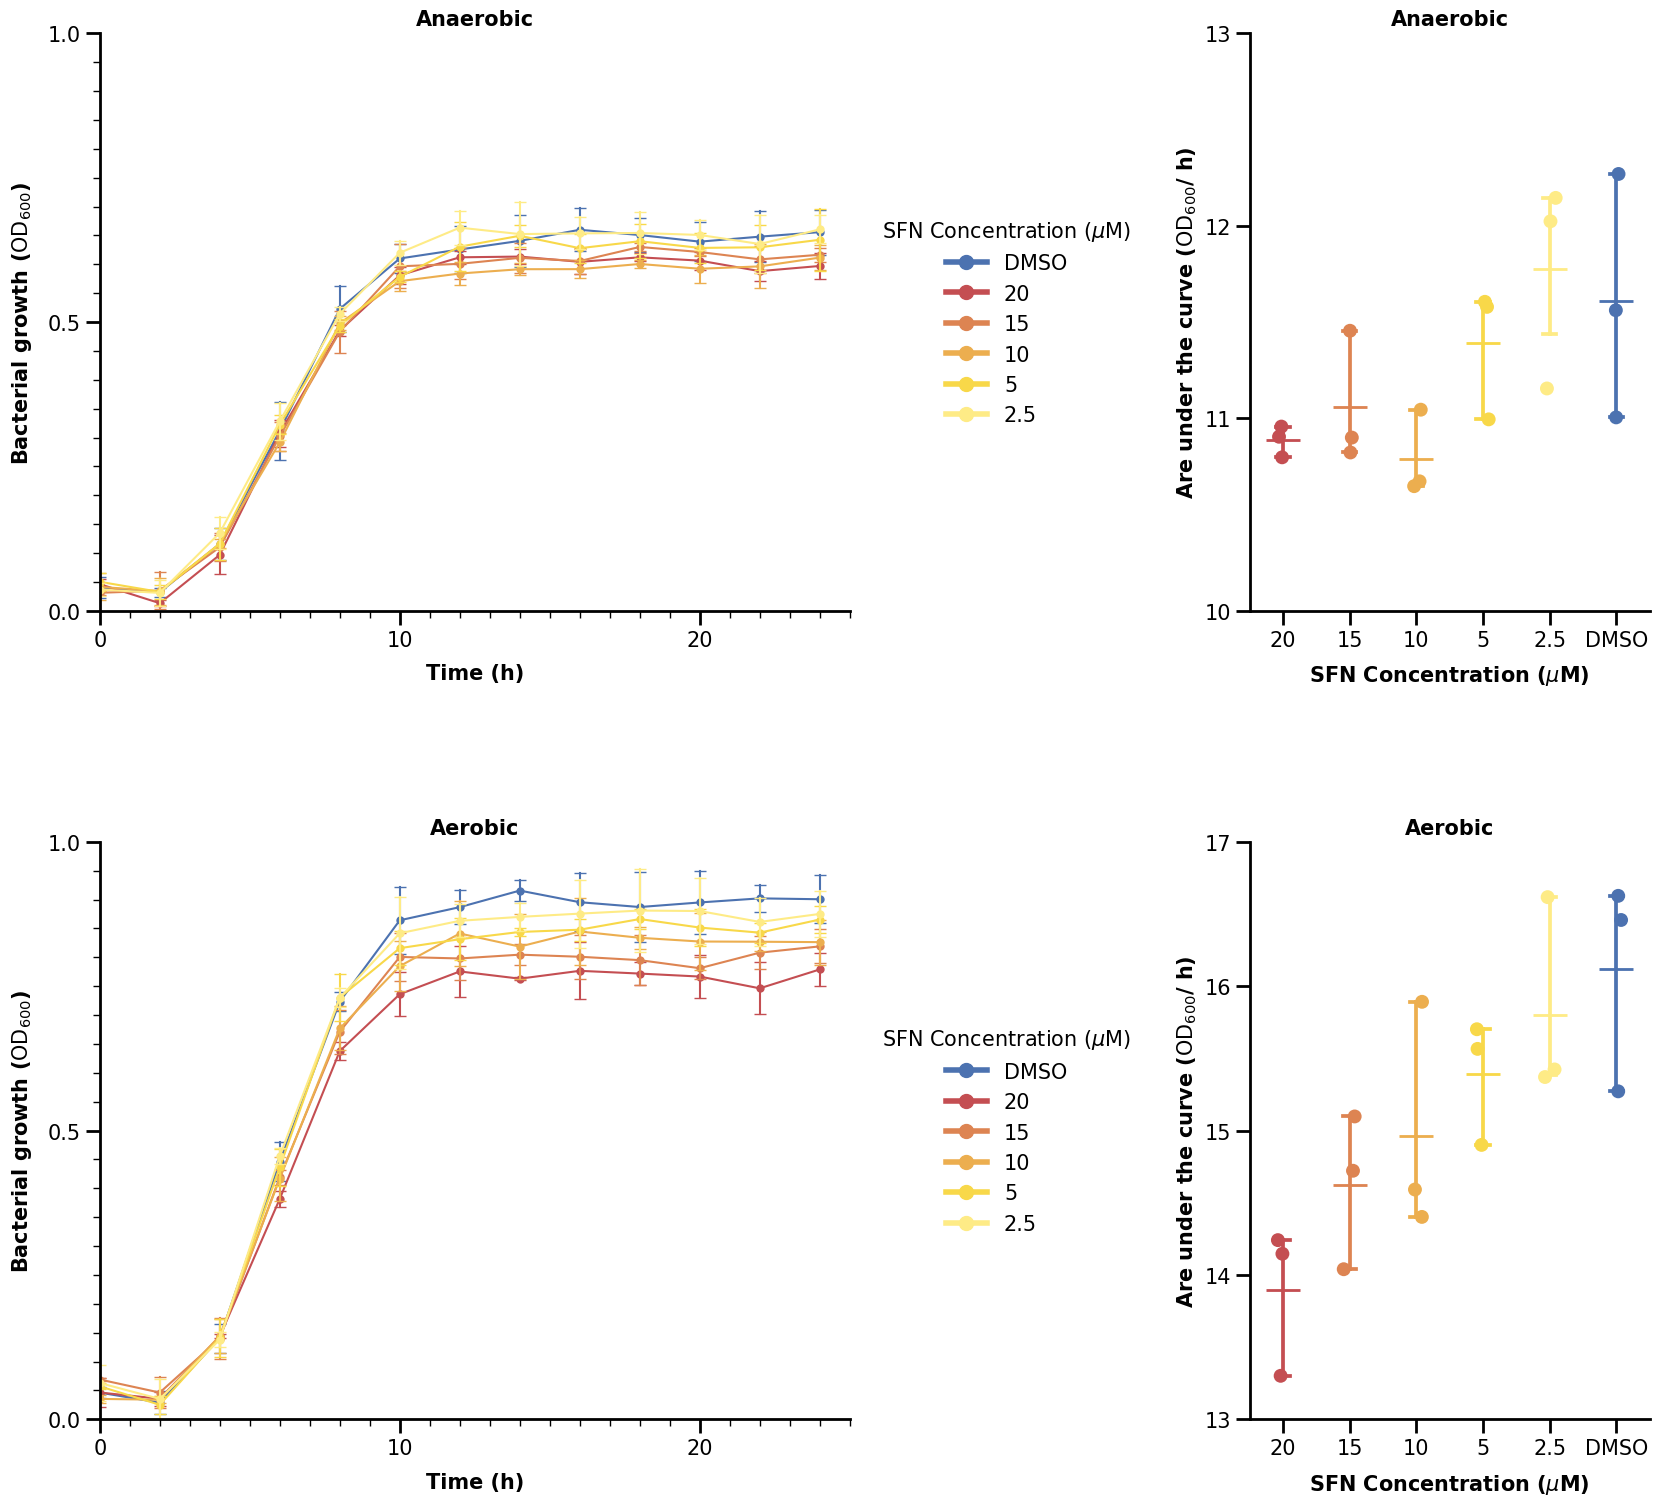

In [145]:
fig = plt.figure(figsize=(20, 18))

gs_line = fig.add_gridspec(nrows=2, ncols=1, right=0.5, hspace=0.4)
gs_cat = fig.add_gridspec(nrows=2, ncols=1, left=0.7, hspace=0.4)

for r, cond in enumerate(["Anaerobic", "Aerobic"]):
    if r == 0:
        cat_lims = (10, 13)
    else:
        cat_lims = (13, 17)
    for c in range(2):
        if c == 0:
            ax = fig.add_subplot(gs_line[r])
            plot_lineplot(data, cond, (0, 25), (0, 1.0), ax)

        else:
            ax = fig.add_subplot(gs_cat[r])
            plot_categorical_plot(data_auc, cond, cat_lims, ax)

plt.show()

Using Gridspec, we can have a large variety of possible figure layouts.

Let us finish the remainding elements of the figure and with it, this chapter.

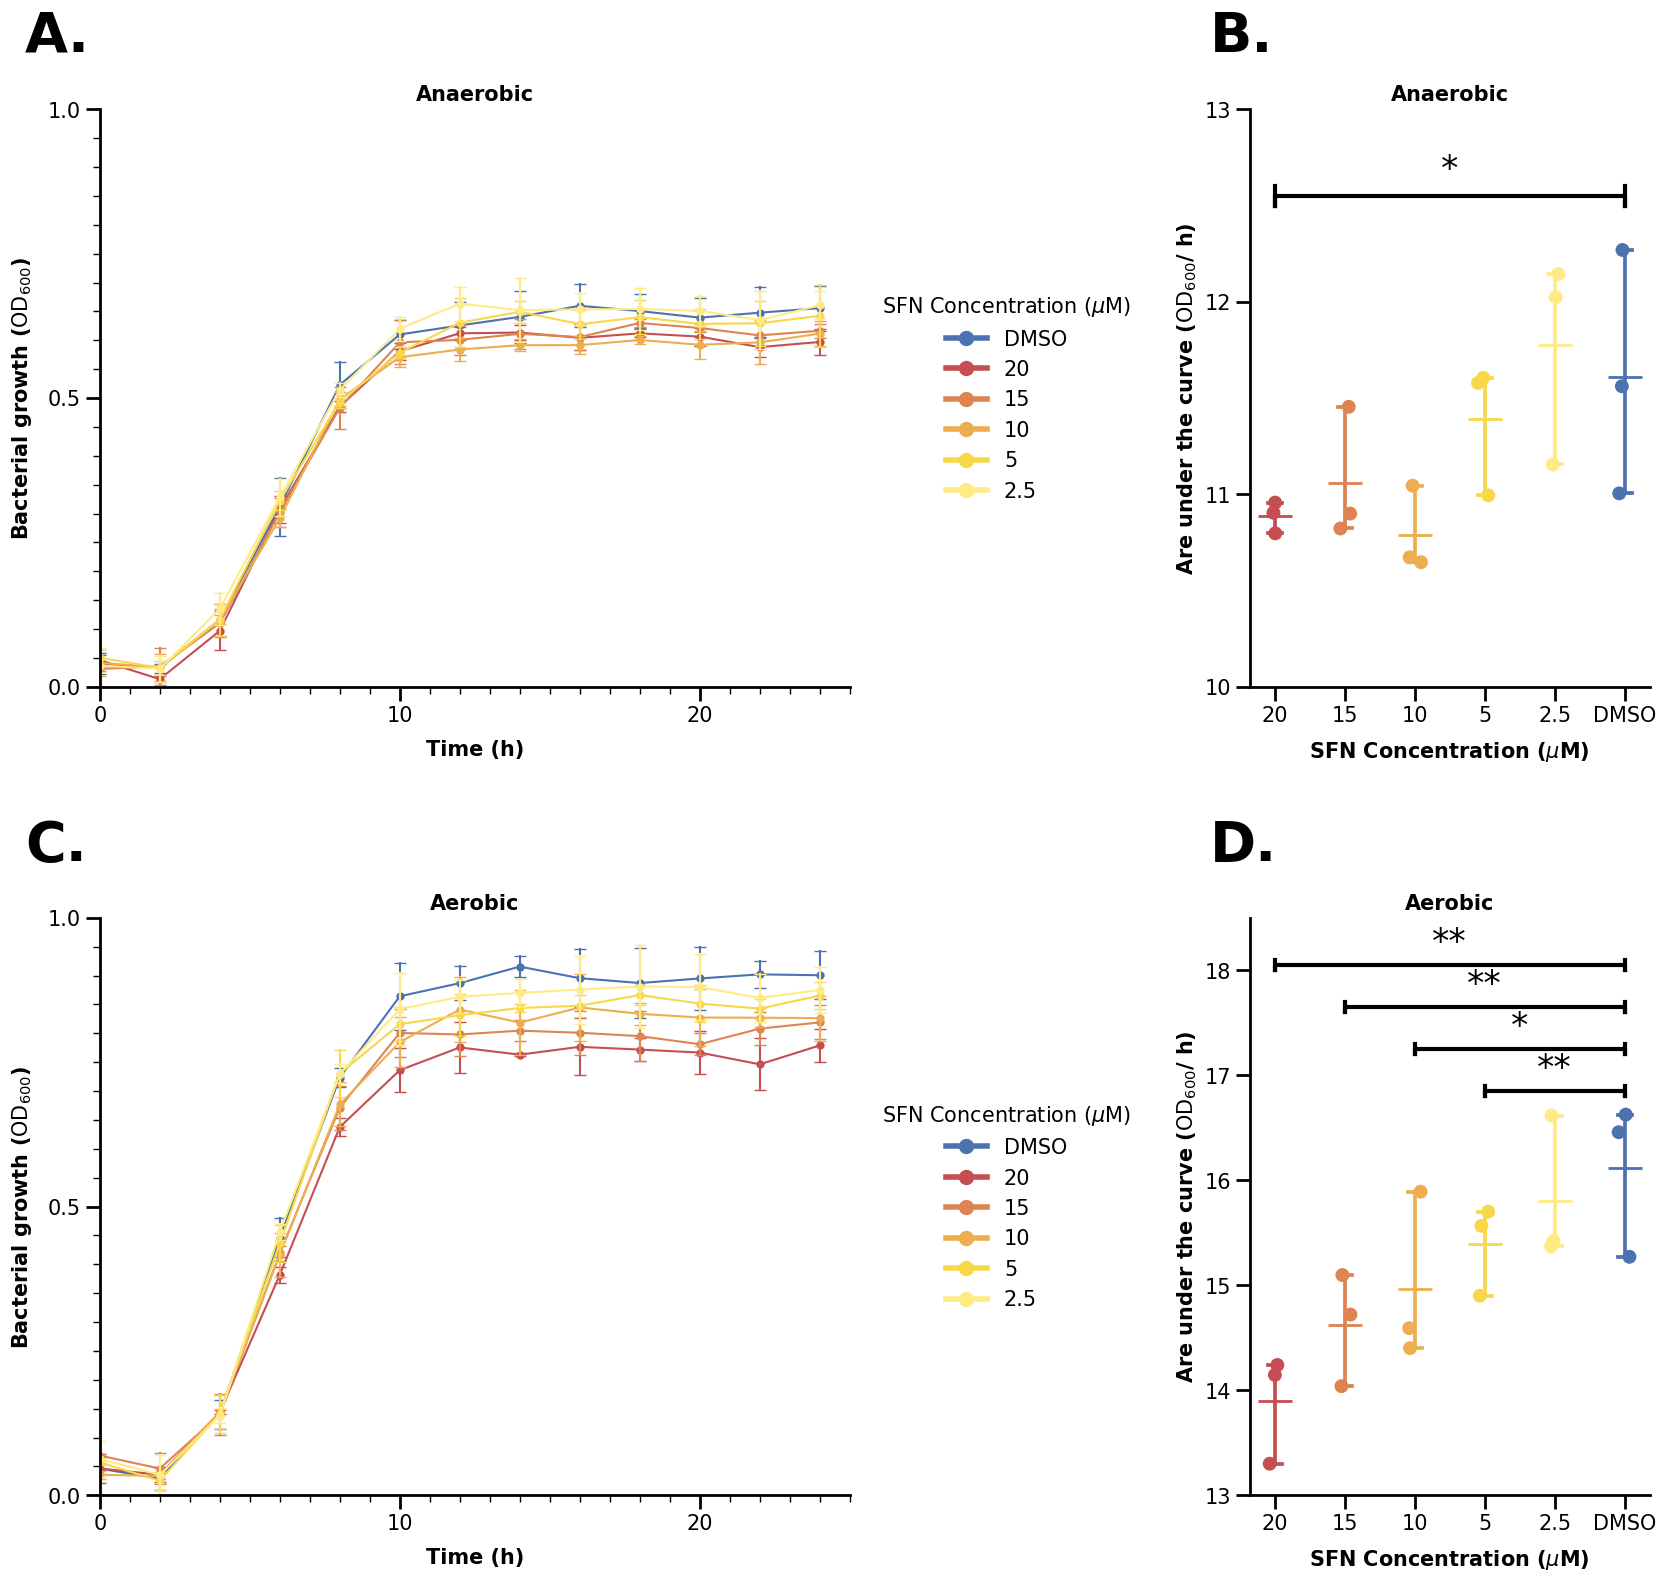

In [169]:
letter_list = ["A.", "B.", "C.", "D."]

fig = plt.figure(figsize=(20, 18))

gs_line = fig.add_gridspec(nrows=2, ncols=1, right=0.5, hspace=0.4)
gs_cat = fig.add_gridspec(nrows=2, ncols=1, left=0.7, hspace=0.4)

count = 0
for r, cond in enumerate(["Anaerobic", "Aerobic"]):
    if r == 0:
        cat_lims = (10, 13)
    else:
        cat_lims = (13, 18.5)
    for c in range(2):
        if c == 0:
            ax = fig.add_subplot(gs_line[r])
            plot_lineplot(data, cond, (0, 25), (0, 1.0), ax)

        else:
            ax = fig.add_subplot(gs_cat[r])
            plot_categorical_plot(data_auc, cond, cat_lims, ax)

            if r == 0:
                plot_significance([(0, 5)], [12.5], labels=["*"], ax=ax)
            else:
                plot_significance(
                    [(3, 5), (2, 5), (1, 5), (0, 5)],
                    [16.8, 17.2, 17.6, 18.0],
                    labels=["**", "*", "**", "**"],
                    ax=ax,
                )

        ax.text(
            -0.1,
            1.1,
            letter_list[count],
            transform=ax.transAxes,
            fontsize=40,
            weight="bold",
        )
        count += 1

plt.show()